In [28]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
df = pd.read_csv("augmented_data.csv")
df.head()

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_25448\1741962474.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("augmented_data.csv")


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,2,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df = df.drop(columns=['child_alone'])
filtered_df = df[df['related'] <= 1]
df = filtered_df.copy()
df.drop_duplicates(subset=['id'], keep='first', inplace=True)
df = df.drop_duplicates(keep='first')

In [30]:
df_categories = df.drop(['id', 'message','original','genre'], axis=1)
counts = []
categories = list(df_categories.columns.values)
for i in categories:
    counts.append((i, df_categories[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_messages'])
df_stats

,category,number_of_messages
0,related,19957
1,request,4503
2,offer,118
3,aid_related,10895
4,medical_help,2091
5,medical_products,1315
6,search_and_rescue,724
7,security,471
8,military,864
9,water,1678


Text(0.5, 0, 'category')

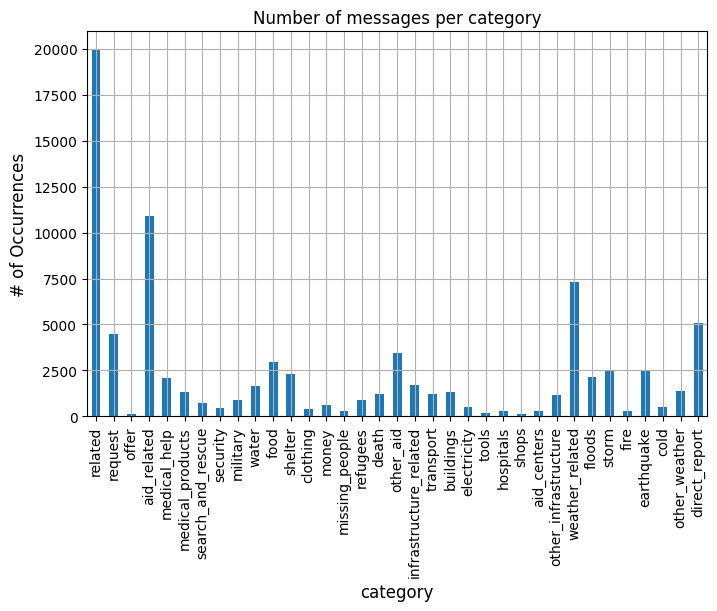

In [31]:
df_stats.plot(x='category', y='number_of_messages', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of messages per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

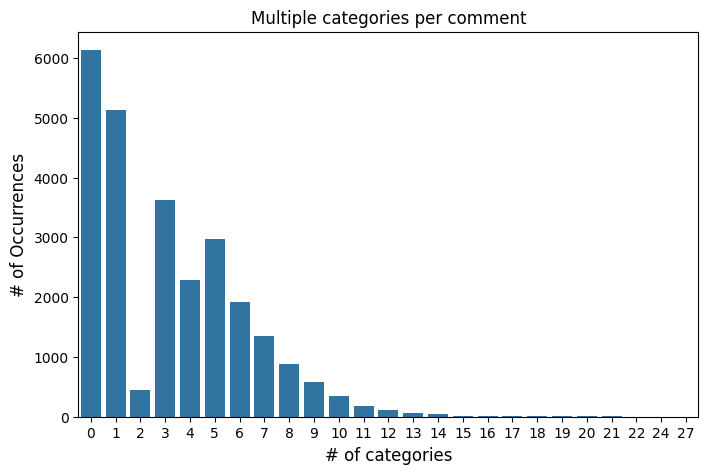

In [32]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
# print(x)
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x = x.index, y = x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

<Axes: >

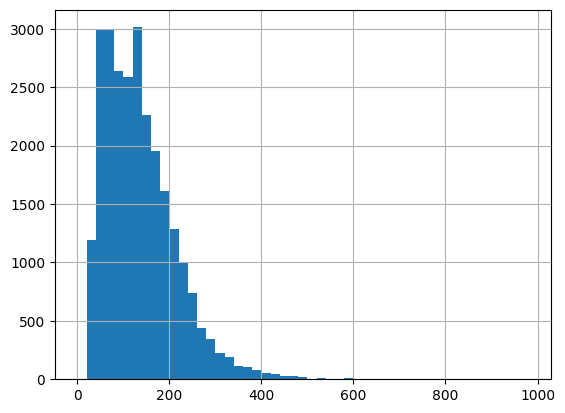

In [26]:
lens = df.message.str.len()
lens.hist(bins = np.arange(0,1000,20))

In [33]:
def tokenize(text,url_place_holder_string="urlplaceholder"):

    # Replace all urls with a urlplaceholder string
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Extract all the urls from the provided text 
    detected_urls = re.findall(url_regex, text)
    
    # Replace url with a url placeholder string
    for detected_url in detected_urls:
        text = text.replace(detected_url, url_place_holder_string)

    # Extract the word tokens from the provided text
    tokens = nltk.word_tokenize(text)
    
    #Lemmanitizer to remove inflectional and derivationally related forms of a word
    lemmatizer = nltk.WordNetLemmatizer()

    # List of clean tokens
    clean_tokens = [lemmatizer.lemmatize(w).lower().strip() for w in tokens]
    return clean_tokens

<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\('
C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_25448\2102086651.py:4: SyntaxWarning: invalid escape sequence '\('
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


In [44]:
from scipy.stats import gmean
# import relevant functions/modules from the sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report #generate test report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin

In [37]:
# Build a custom transformer which will extract the starting verb of a sentence
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    # Given it is a tranformer we can return the self 
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [45]:
pipeline1 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transformer', TfidfTransformer())
            ]))
            
        ])),

        ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
    ])

pipeline2 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transformer', TfidfTransformer())
            ])),

            ('starting_verb_transformer', StartingVerbExtractor())
        ])),

        ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
    ])


#pipeline = Pipeline(
#                    [('count_vectorizer', CountVectorizer(tokenizer = tokenize)),
#                     ('tfidf_transformer', TfidfTransformer()),
#                     ('rf_classifier', RandomForestClassifier())
#                     ])

In [46]:
X = df['message']
y = df.iloc[:,4:]

In [48]:
import nltk

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline_fitted = pipeline1.fit(X_train, y_train)

c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

In [50]:
y_prediction_train = pipeline_fitted.predict(X_train)
y_prediction_test = pipeline_fitted.predict(X_test)

# Print classification report on test data
print(classification_report(y_test.values, y_prediction_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.84      0.94      0.88      5003
               request       0.78      0.57      0.65      1142
                 offer       0.12      0.03      0.05        32
           aid_related       0.76      0.62      0.68      2716
          medical_help       0.59      0.27      0.37       530
      medical_products       0.71      0.38      0.49       326
     search_and_rescue       0.52      0.17      0.26       185
              security       0.32      0.06      0.10       106
              military       0.68      0.31      0.42       199
                 water       0.74      0.67      0.70       463
                  food       0.83      0.69      0.75       767
               shelter       0.79      0.58      0.67       586
              clothing       0.67      0.40      0.50        99
                 money       0.39      0.21      0.27       144
        missing_people       0.61      

c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO LEGION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
